<a href="https://colab.research.google.com/github/rodrigorenemenegazzo/Artificial-Intelligence/blob/main/TF04_RNN_Passageiros_Predi%C3%A7%C3%A3o_de_S%C3%A9rie_Temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rodrigo Rene Menegazzo

Prática: Predição Passageiros de Companhia Aérea
  * Predizer ocupação de passageiros



Importações

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.__version__

'2.8.2'

Carga da base

--2022-06-14 14:45:45--  http://www.razer.net.br/datasets/airline-passengers.csv
Resolving www.razer.net.br (www.razer.net.br)... 178.128.150.229
Connecting to www.razer.net.br (www.razer.net.br)|178.128.150.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/csv]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-06-14 14:45:45 (249 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



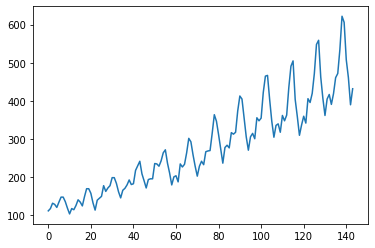

In [2]:
!wget http://www.razer.net.br/datasets/airline-passengers.csv
df = pd.read_csv("airline-passengers.csv", usecols=[1])
df.head()
plt.plot(df)
plt.show()

Pré-processamento

In [3]:
series = df.values
series = series.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)
# tamanho da base de treino – 67% do total
train_size = int(len(series) * 0.67)

Conversão da base em dataset

In [4]:
T = 10 #tamanho da janela usada para previsão(10 leituras p/ predizer a próxima)
D = 1 #quantidade de informação em cada leitura simples, 1 no caso do preço de uma ação, 2 no caso de GPS...
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Fica N x T x D
Y = np.array(Y)
N = len(X) #número de janelas disponíveis na série temporal, de 10 em 10...
print("X.shape: ", X.shape, " Y.shape: ", Y.shape)

X.shape:  (134, 10, 1)  Y.shape:  (134, 1)


Criação do modelo

In [5]:
i = Input(shape=(T, 1))
#x = SimpleRNN(5, activation=None)(i)
x = SimpleRNN(5, activation="relu")(i)
#x = SimpleRNN(5)(i) # tanh por default
x = Dense(1)(x)
model = Model(i, x)

Compilação e ajuste do modelo

In [6]:
model.compile(
loss="mse",
optimizer=Adam(lr=0.1)
)
r = model.fit(
X[:train_size], Y[:train_size],
epochs=80,
validation_data=(X[-train_size:], Y[-train_size:])
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
3/3 [==============================] - 3s 283ms/step - loss: 0.3061 - val_loss: 0.2898
Epoch 2/80
3/3 [==============================] - 0s 53ms/step - loss: 0.0907 - val_loss: 0.0324
Epoch 3/80
3/3 [==============================] - 0s 89ms/step - loss: 0.0372 - val_loss: 0.0178
Epoch 4/80
3/3 [==============================] - 0s 43ms/step - loss: 0.0241 - val_loss: 0.0458
Epoch 5/80
3/3 [==============================] - 0s 38ms/step - loss: 0.0177 - val_loss: 0.0781
Epoch 6/80
3/3 [==============================] - 0s 48ms/step - loss: 0.0213 - val_loss: 0.0583
Epoch 7/80
3/3 [==============================] - 0s 40ms/step - loss: 0.0150 - val_loss: 0.0296
Epoch 8/80
3/3 [==============================] - 0s 59ms/step - loss: 0.0127 - val_loss: 0.0185
Epoch 9/80
3/3 [==============================] - 0s 39ms/step - loss: 0.0130 - val_loss: 0.0197
Epoch 10/80
3/3 [==============================] - 0s 30ms/step - loss: 0.0098 - val_loss: 0.0262
Epoch 11/80
3/3 [===========

Plotar a função de perda

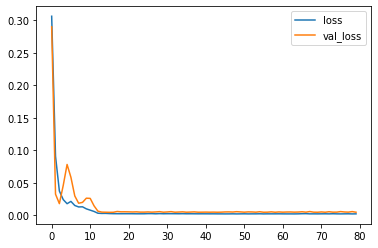

In [7]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

Predições: 1-step

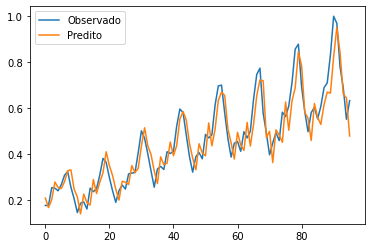

In [8]:
validation_target = Y[-train_size:]
validation_predictions = []
i = -train_size

while len(validation_predictions) < len(validation_target):
  p = model.predict( X[i].reshape(1, -1, 1))[0, 0]
  i += 1

  validation_predictions.append(p)

plt.plot(validation_target, label="Observado")
plt.plot(validation_predictions, label="Predito")
plt.legend()

Multi-step

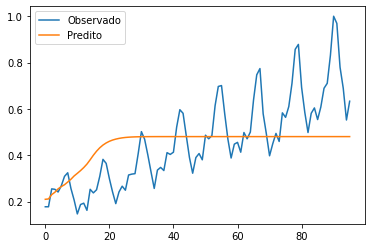

In [50]:
validation_target = Y[-train_size:]
validation_predictions = []
last_x = X[-train_size]

while len(validation_predictions) < len(validation_target):
  p = model.predict( last_x.reshape(1, -1, 1))[0, 0]
  
  validation_predictions.append(p)
  
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label="Observado")
plt.plot(validation_predictions, label="Predito")
plt.legend()